# Nutrient analysis of freshwater + marine fish data

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import theano.tensor as tt
from pymc3.backends import SQLite
import seaborn as sns
import scipy as sp
import matplotlib as mp
import arviz as az
import pdb

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

In [3]:
def pairplot_divergence(trace, basevar, targetvar, ax=None, divergence=True, color='C3', divergence_color='C2'):
    #theta = trace.get_values(varname=basevar, combine=True)[:, 0]
    theta = trace.get_values(varname=basevar, combine=True)
    logtau = trace.get_values(varname=targetvar, combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(theta[divergent], logtau[divergent], 'o', color=divergence_color)
    ax.set_xlabel(basevar)
    ax.set_ylabel(targetvar)
    ax.set_title('scatter plot between log('+targetvar+') and '+basevar);
    return ax

# A small wrapper function for displaying the MCMC sampler diagnostics as above
def report_trace(trace,basevar,targetvar,logscale=False):
    # plot the trace of log(tau)
    pm.traceplot({targetvar: trace.get_values(varname=targetvar, combine=False)});

    # plot the estimate for the mean of log(τ) cumulating mean
    if logscale:
        logtau = np.log(trace[targetvar])
    else:
        logtau = trace[targetvar]
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    #plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log('+targetvar+')')
    plt.title('MCMC estimation of log('+targetvar+')')
    plt.show()

    # display the total number and percentage of divergent
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size / len(trace) * 100
    print('Percentage of Divergent %.1f' % divperc)

    # scatter plot between log(tau) and theta[0]
    # for the identifcation of the problematic neighborhoods in parameter space
    pairplot_divergence(trace,basevar,targetvar);

## Import data

In [66]:
# Nutrition + traits data
ndata = pd.read_csv('MeasuredNutrients.csv')

In [67]:
ndata.head()

,Unnamed: 0,Search,Year,GeographicLocation_Cleaned,DemersPelag,Form_Clean,Species_from_search,Family,Order,DepthRangeDeep,BodyShapeI,LMax,EnvTemp,trophic_level,K,tm,nutrient,nutvalue,Habitat
0,109,WOS,2009.0,Portugal,pelagic,muscle,Aphanopus_carbo,Trichiuridae,Perciformes,1700.0,elongate,115.4,polar_deep,4.500000,0.11,5.331634,Calcium,14.0,Marine
1,110,WOS,2015.0,Bangladesh,benthopelagic,whole_parts,Pampus_argenteus,Stromateidae,Perciformes,110.0,short_deep,60.0,subtropical,3.300000,0.45,1.631748,Calcium,31.0,Marine
2,111,WOS,2015.0,Bangladesh,pelagic_neritic,whole_parts,Stolephorus_tri,Engraulidae,Clupeiformes,50.0,fusiform,9.5,tropical,3.233333,1.03,0.800000,Calcium,1500.0,Marine
3,112,WOS,2015.0,Bangladesh,demersal,whole_parts,Johnius_belangerii,Sciaenidae,Perciformes,40.0,fusiform,30.0,tropical,3.270000,0.57,1.300000,Calcium,1900.0,Marine
4,113,WOS,2015.0,Bangladesh,pelagic_neritic,whole_parts,Scomberomorus_guttatus,Scombridae,Perciformes,200.0,fusiform,76.0,tropical,4.300000,0.34,1.900000,Calcium,34.0,Marine


### Datasets

In [68]:
Nutrients = ['Protein', 'Zinc', 'Iron', 'Calcium', 'Omega-3', 'Vitamin_A', 'Selenium']
nnutrients = len(Nutrients)

In [69]:
# Sample sizes for each nutrient
[sum(ndata.nutrient.values==n) for n in Nutrients]

[818, 385, 359, 342, 200, 69, 203]

## ======= Loop over nutrients ========= #

In [70]:
i = 3
nut = Nutrients[i]
nut

'Calcium'

In [71]:
# Grab dataframe with nutrient of interest
tmp_data = ndata.loc[ndata.nutrient==nut].copy()

# Response variable
Y_ = tmp_data.nutvalue.values

In [72]:
len(Y_)

342

In [73]:
# Units
#'Protein' - g/100g OK
#'Zinc' - mg/100g
#'Iron' - mg/100g
#'Calcium' - mg/100g OK
#'Omega-3': - g/100g
#'Vitamin_A' - μg/100g OK
#'Selenium' - μg/100g OK

# NA Filter
indx = np.isfinite(Y_)

### ZEROS Filter
if nut in ['Selenium', 'Calcium']:
    indx = indx*(Y_>0)
    
### Protein beyond 60% Filter
if nut in ['Protein']:
    indx = indx*(Y_<60)
    
### Zinc beyond 11 Filter
#if nut in ['Zinc']:
#    indx = indx*(Y_<10)
    
### Omega-3 beyond 610 Filter
if nut in ['Omega-3']:
    indx = indx*(Y_<10)

# Remove non-useful data
Y_ = Y_[indx]

# Unit conversions for better models
if nut in ['Omega-3']:
    Y_ = Y_*10

    
# Log-scale
Ylog = np.log(Y_+1)

# Observation scale
Y = Y_

# Filter dataframe if necessary
tmpdata = tmp_data[indx]

# Index for orders
Order,Io = subindexall(tmpdata.Order.values, tmpdata['Species_from_search'].values)
nord = len(Order)

# Index for species
spxs = list(tmpdata['Species_from_search'].values)
sindx = np.array([spxs.index(s) for s in np.unique(spxs)])

# Species-level covariates
Habitat,Ih = subindexall(tmpdata['DemersPelag'].values, tmpdata['Species_from_search'].values)
nhabs = len(Habitat)
Climate,Ic = subindexall(tmpdata['EnvTemp'].values, tmpdata['Species_from_search'].values)
nclim = len(Climate)
MaxDepth = np.log(tmpdata['DepthRangeDeep'].values)[sindx]
TL = tmpdata['trophic_level'].values[sindx]
#FeedPath, Ifp = indexall(tmpdata['Feeding_path'].values[sindx])
#nfp = len(FeedPath)
LMax = np.log(tmpdata['LMax'].values)[sindx]
Body,Ib = subindexall(tmpdata['BodyShapeI'].values, tmpdata['Species_from_search'].values)
nbod = len(Body)
K = tmpdata['K'].values[sindx]
tm = np.log(tmpdata['tm'].values)[sindx]

# Nussiance parameters
Form,If = indexall(tmpdata['Form_Clean'].values)
nform = len(Form)
#Prep,Ip = indexall(tmpdata['Prep'].values)
#nprep = len(Prep)
Search,Is = indexall(tmpdata['Search'].values)
nsearch = len(Search)


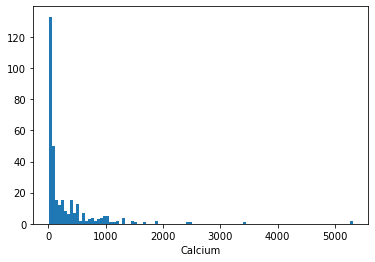

In [77]:
plt.hist(Y,bins=100)
plt.xlabel(nut);

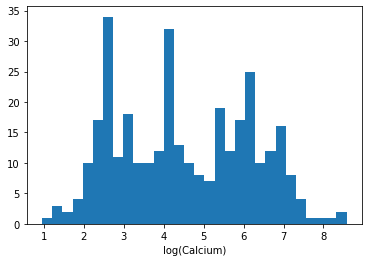

In [78]:
plt.hist(Ylog,bins=30)
plt.xlabel('log('+nut+')');

## Specify model

In [80]:
with pm.Model() as Hicks:
    # Intercept
    γ0 = pm.Normal('Intercept', 0, 5)
    # Order model
    σγ = pm.Uniform('Sigma_γ', 0, 100)
    #β0 = pm.Normal('Order', mu=γ0, sd=σγ, shape=nord)
    pi_tilde = pm.Normal('pi_t', 0, 1, shape=nord)
    β0 = pm.Deterministic('Order', γ0 + σγ*pi_tilde)
    # Random effect of data-source
    #β01 = pm.Normal('Geography', 0, 1, shape=ngeo)
    
    #"""
    # Habitat type
    β1 = pm.Normal('Habitat', 0, 1, shape=nhabs)
    # Climate
    β2 = pm.Normal('Climate', 0, 1, shape=nclim)
    # Maximum Depth
    β3 = pm.Normal('MaxDepth', 0, 1)
    # Total Length
    β4 = pm.Normal('TL', 0, 1)
    # Pelagic/demersal
    #β5 = pm.Normal('FeedPath', 0, 1, shape=nfp)
    # Maximum length
    β6 = pm.Normal('LMax', 0, 1)
    # Body form
    β7 = pm.Normal('Body', 0, 1, shape=nbod)
    # Growth parameter
    β8 = pm.Normal('K', 0, 1)
    # Age at maturity
    β9 = pm.Normal('tm', 0, 1)
    
    # Form of sample
    β10 = pm.Normal('Form', 0, 1, shape=nform)
    # Form of prepartion
    #β11 = pm.Normal('Prep', 0, 1, shape=nprep)
    # Database used
    β12 = pm.Normal('Search', 0, 1, shape=nsearch)
    
    #"""
    
    # Mean model
    mu = γ0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β12[Is]
    
    # Observation model
    #μ_ = mu[Isp]+β10[If]+β12[Is]
    μ_ = mu
    
    # Gamma model
    μ = tt.exp(μ_)
    α = pm.Gamma('α', 2, 2)
    Yi = pm.Gamma('Yi', alpha=α, beta=α/μ, observed=Ylog)

ValueError: Input dimension mis-match. (input[0].shape[0] = 155, input[1].shape[0] = 330)

In [ ]:
for RV in Hicks.basic_RVs:
    print(RV.name, RV.logp(Hicks.test_point))

In [ ]:
# Sampling
with Hicks:
    # Draw samples
    trace_Hicks = pm.sample(1000)

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


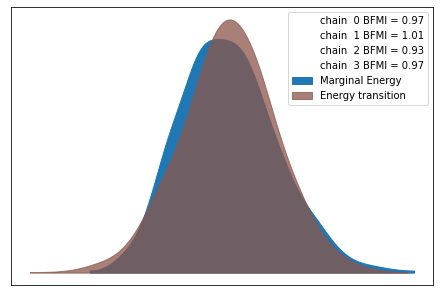

In [42]:
pm.plots.energyplot(trace_Hicks);

In [43]:
pm.waic(trace_Hicks, scale='deviance')

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 158 log-likelihood matrix

              Estimate       SE
deviance_waic   473.26    21.69
p_waic           17.75        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [44]:
Hicks_posterior = az.from_pymc3(trace_Hicks)

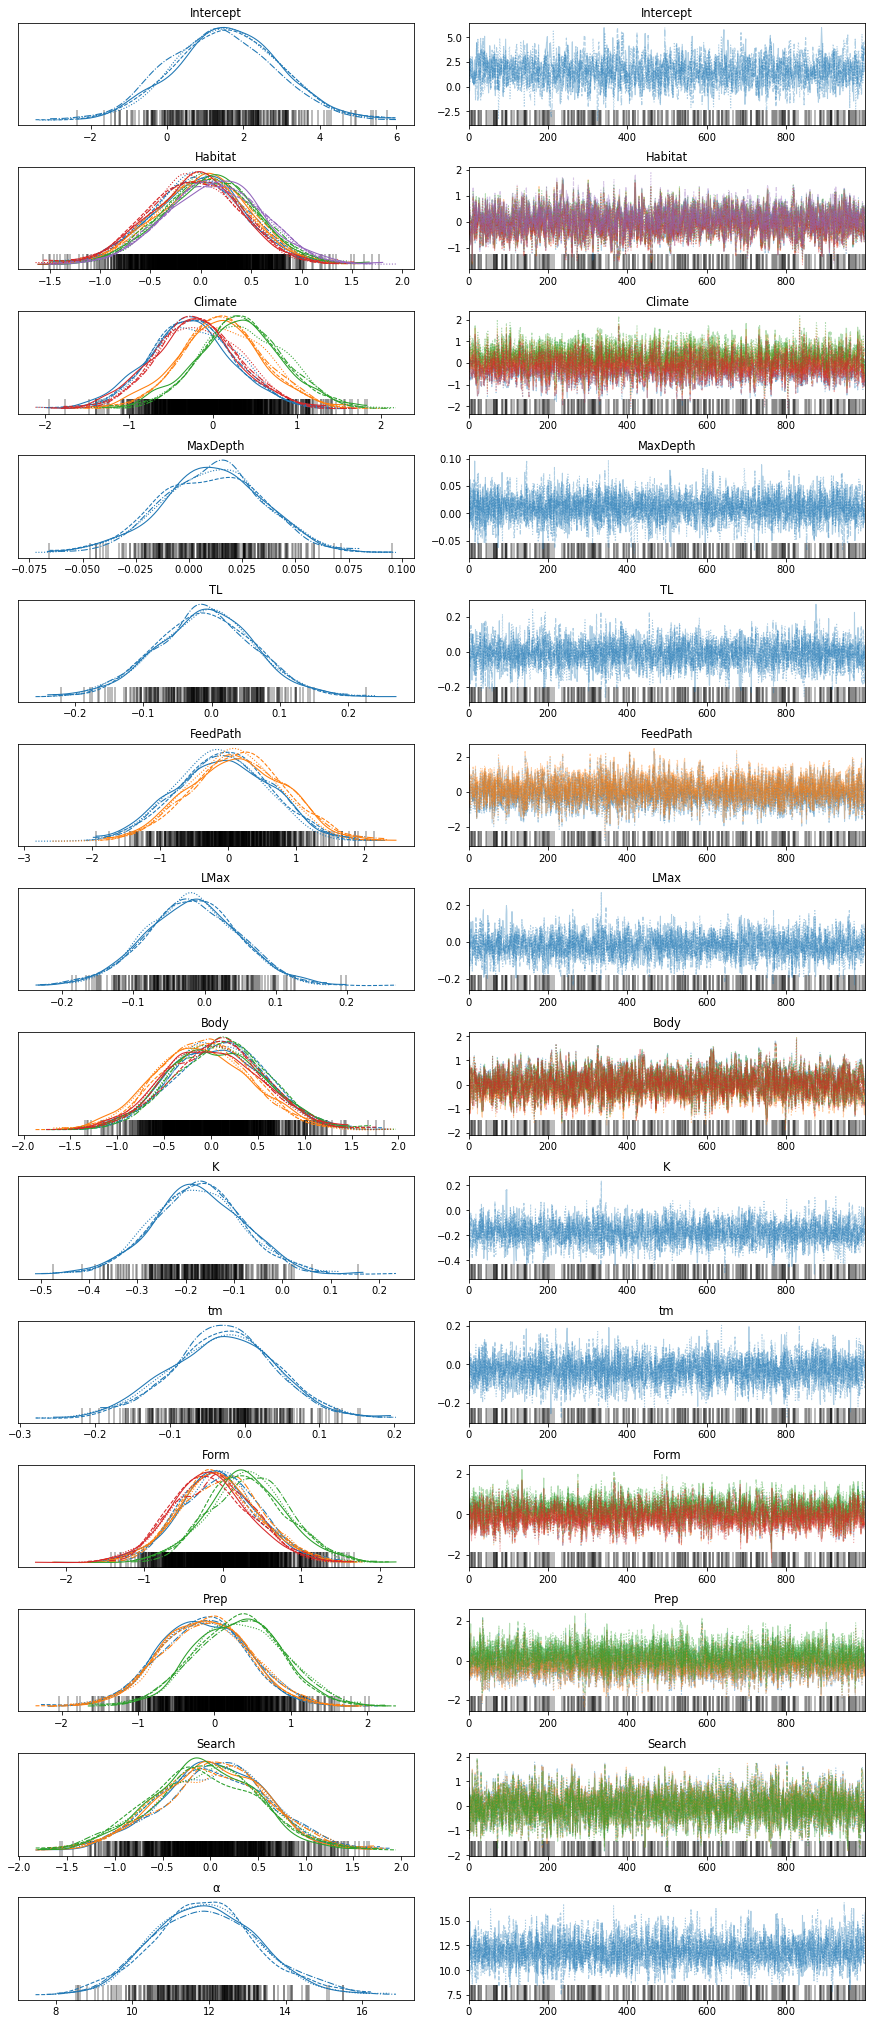

In [45]:
az.plot_trace(Hicks_posterior, compact=True);

In [46]:
model_compare = az.compare({'Hicks':trace_Hicks,'Phylogenetic':trace_Phylo_GP}, scale='deviance')
model_compare

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:682: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future r

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Phylogenetic,0,471.945,26.347,0,0.751385,21.9208,0,True,deviance
Hicks,1,474.954,18.6026,3.00963,0.248615,21.7558,2.74578,True,deviance


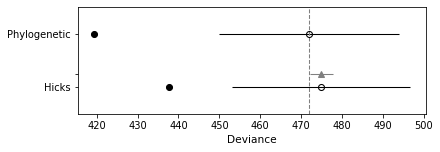

In [47]:
az.plot_compare(model_compare)